In [28]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib_inline
from pathlib import Path
# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
import json
import cv2
from wordcloud import WordCloud, STOPWORDS

In [10]:
DATA_PATH = Path("/data/wr153")

# Features
* average number of words per page in each chapter
* average number of panels per page in each chapter
* ratio of images to words in each chapter
* colors used in memoir
* distribution of sentiment in overall memoir
    * positive, negative, neutral
* word cloud of ideas presented

In [11]:
img = cv2.imread(str(DATA_PATH.joinpath("images", "chapter_24", "223.jpg")))

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours
min_area = 1000
contours = [c for c in contours if cv2.contourArea(c) > min_area]

# Count the remaining contours
num_panels = len(contours)

Text(0.5, 1.0, 'Panels Detected Image')

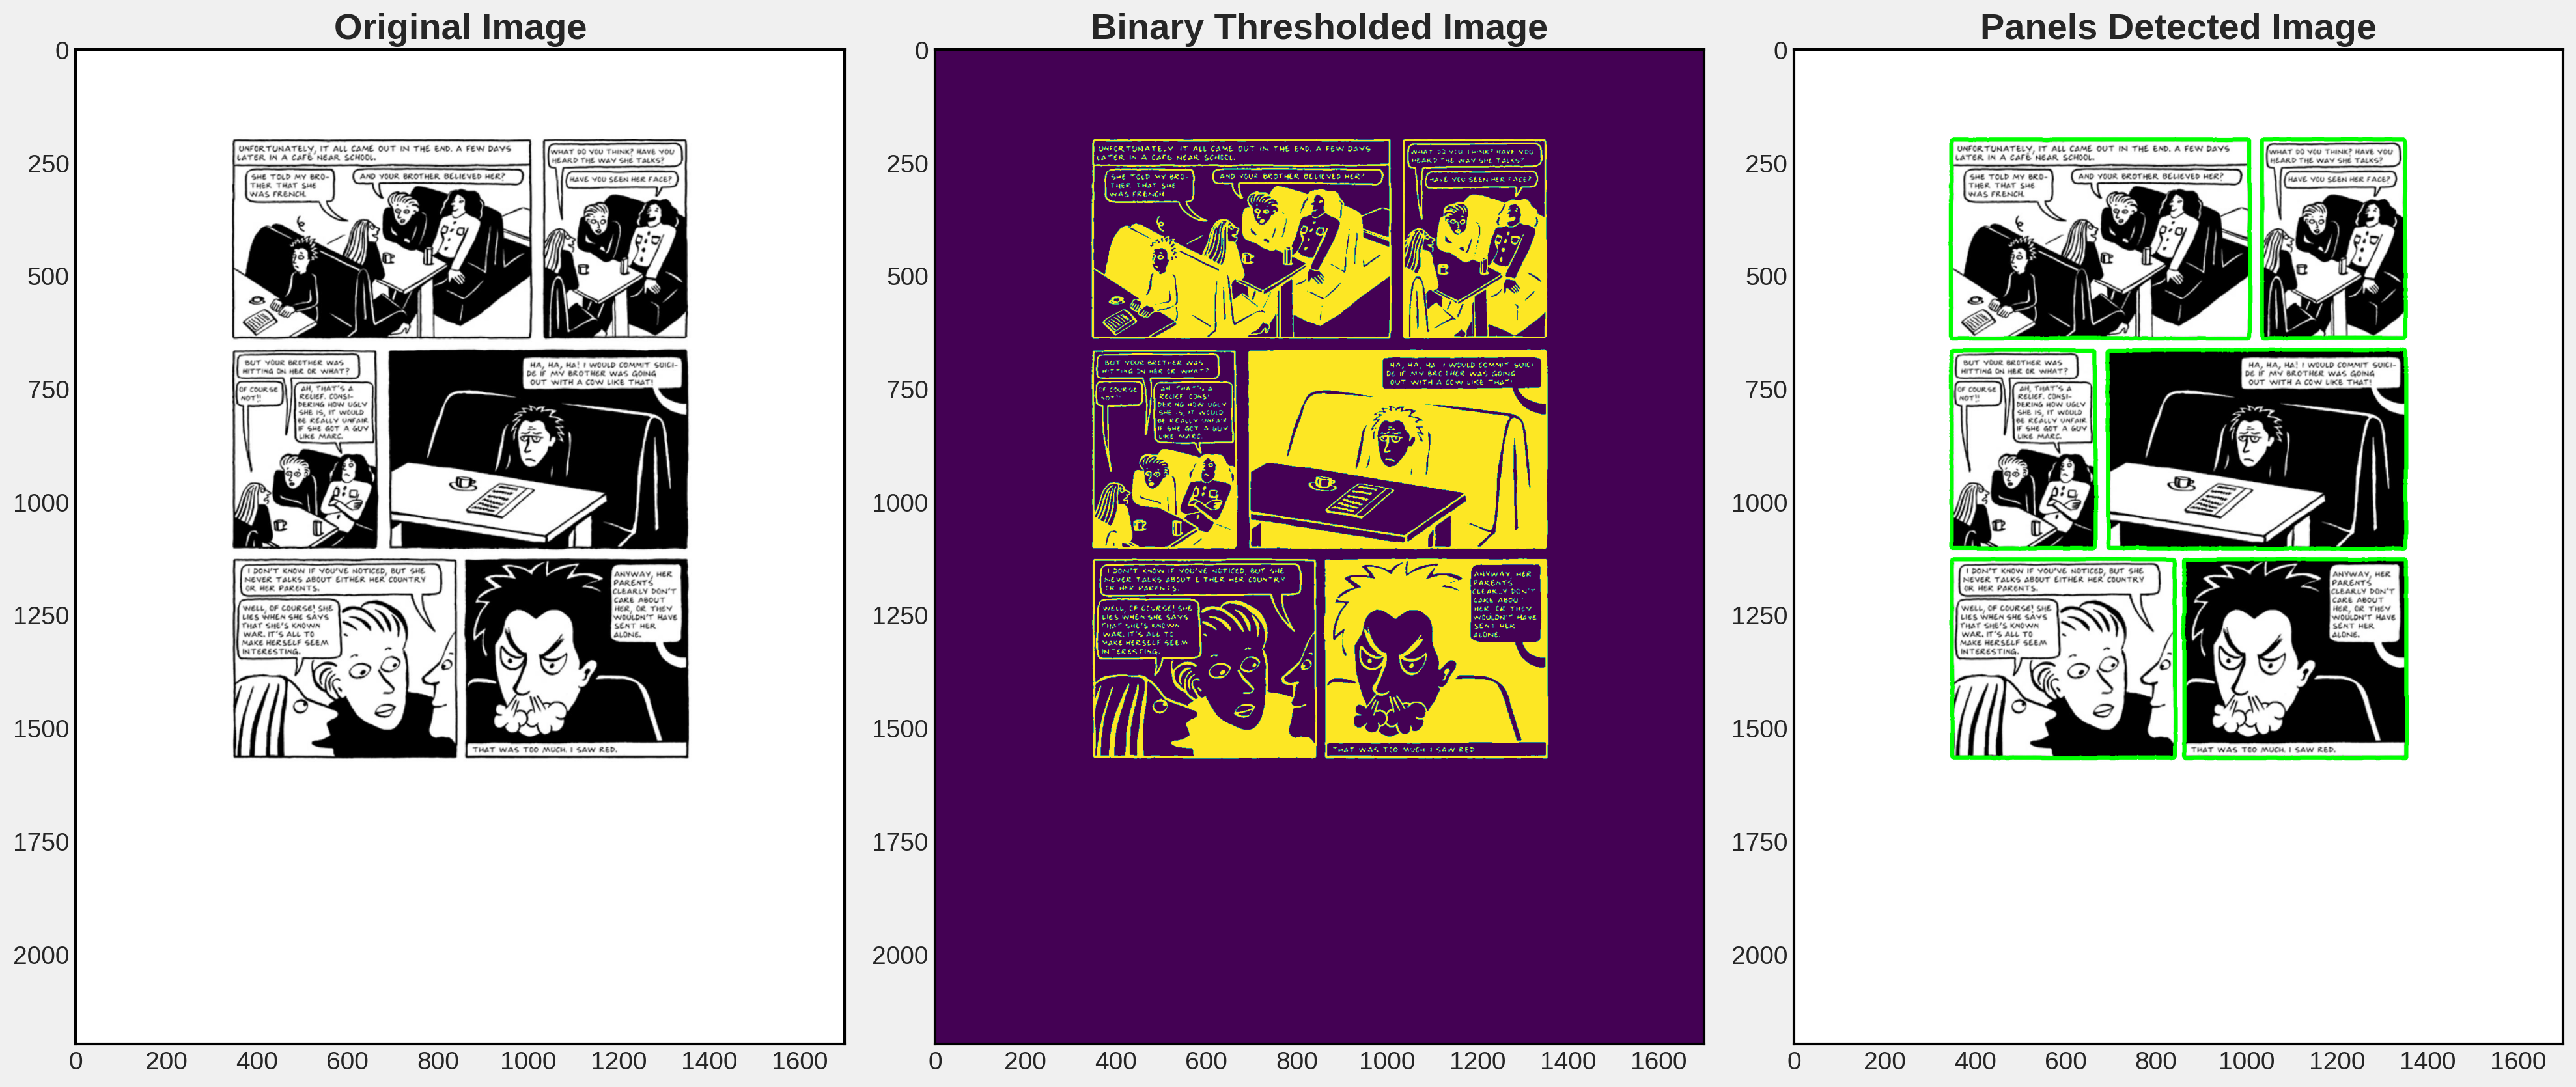

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(img)
axs[0].grid(False)
axs[0].set_title("Original Image")
axs[1].imshow(thresh)
axs[1].grid(False)
axs[1].set_title("Binary Thresholded Image")
axs[2].imshow(cv2.drawContours(img, contours, -1, (0, 255, 0), 8))
axs[2].grid(False)
axs[2].set_title("Panels Detected Image")


In [13]:
def get_num_panels(im_path: Path) -> int:
    img = cv2.imread(str(im_path))

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours
    min_area = 1000
    contours = [c for c in contours if cv2.contourArea(c) > min_area]

    # Count the remaining contours
    num_panels = len(contours)
    
    return num_panels

In [35]:
# generate statistics
data = {"chapter_title": [], "chapter_number": [], "avg_num_words": [], "avg_num_panels": []}
all_text = []
for f in DATA_PATH.joinpath("text").iterdir():
    if f.suffix == ".json":
        with open(f, "rb") as fp:
            d = json.load(fp)
            ch_title = d.pop(sorted(d, key=int)[0])
            data["chapter_title"].append(ch_title)
            n = int(f.stem.split("_")[1])
            data["chapter_number"].append(n)
            num_panels = 0
            l = 0
            for image in DATA_PATH.joinpath("images", f"chapter_{n}").iterdir():
                if image.suffix == ".jpg":
                    panels = get_num_panels(image)
                    num_panels += panels
                    l += 1
            data["avg_num_panels"].append(num_panels / l)
            # remove outliers for words
            remove_keys = []
            for key, val in d.items():
                if len(val.split()) <= 5:
                    remove_keys.append(key)
            for key in remove_keys:
                d.pop(key)
            data["avg_num_words"].append(sum(len(text) for text in d.values()) / len(d))
            for text in d.values():
                all_text.append(text)

In [36]:
df = pd.DataFrame(data)

In [37]:
df.head()

,chapter_title,chapter_number,avg_num_words,avg_num_panels
0,THE DOWRY,19,625.545455,6.416667
1,THE WATER CELL,3,578.000000,6.333333
2,THE MAKEUP,33,890.428571,6.250000
3,THE TRIP,10,793.750000,5.777778
4,THE F-14s,11,633.142857,6.750000


In [39]:
df["chapter_title"] = df["chapter_title"].str.title()
df["avg_word_to_image_ratio"] = df["avg_num_words"] / df["avg_num_panels"]

In [40]:
df.head()

,chapter_title,chapter_number,avg_num_words,avg_num_panels,avg_word_to_image_ratio
0,The Dowry,19,625.545455,6.416667,97.487603
1,The Water Cell,3,578.000000,6.333333,91.263158
2,The Makeup,33,890.428571,6.250000,142.468571
3,The Trip,10,793.750000,5.777778,137.379808
4,The F-14S,11,633.142857,6.750000,93.798942


In [42]:
all_text = " ".join(all_text)

In [55]:
stopwords = STOPWORDS

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000, width=800, height=400).generate(all_text)

In [80]:
common_words = pd.DataFrame([wordcloud.words_.keys(), wordcloud.words_.values()]).T

In [81]:
common_words.rename({0: "word", 1: "relative_frequency"}, axis=1, inplace=True)

In [85]:
common_words["relative_frequency"] = common_words["relative_frequency"].astype(float)

In [87]:
common_words["word"] = common_words["word"].str.lower()
common_words["relative_frequency"] = common_words["relative_frequency"].round(3)

In [88]:
common_words.iloc[:20]

,word,relative_frequency
0,one,1.000
1,know,0.980
2,see,0.839
3,going,0.826
4,time,0.805
5,mother,0.752
6,want,0.752
7,u,0.698
8,go,0.691
9,come,0.691


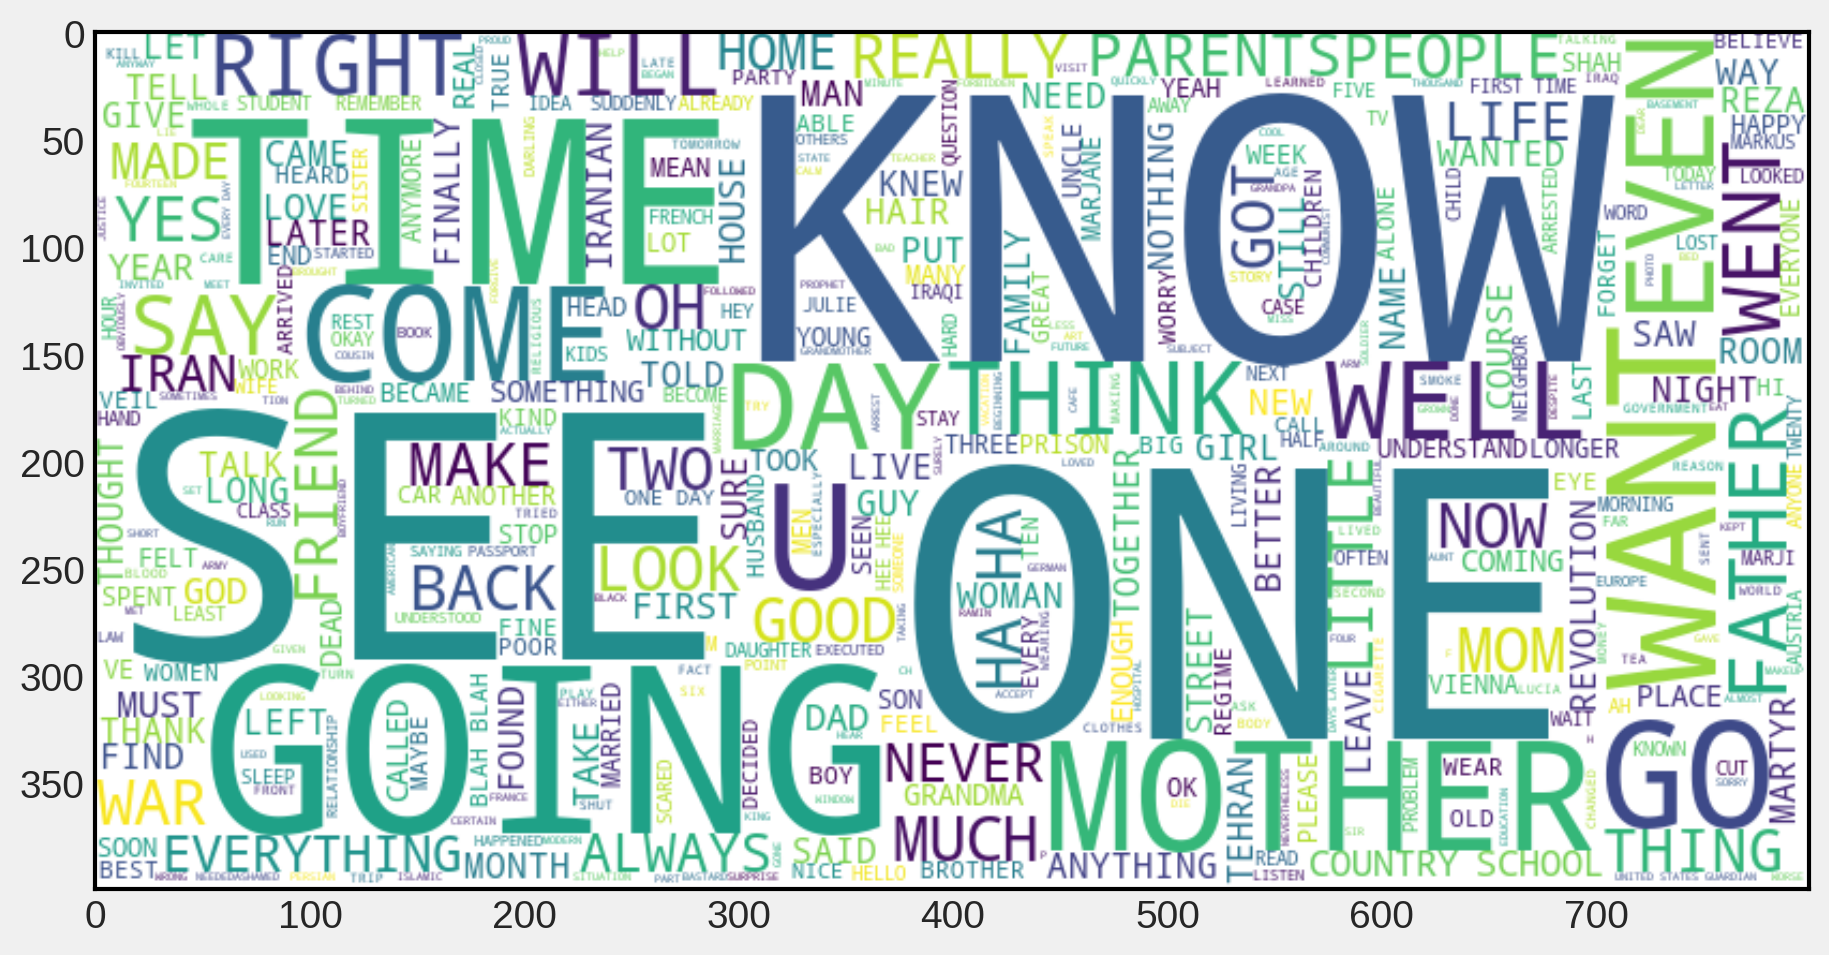

In [58]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.imshow(wordcloud, interpolation='bilinear')
ax.grid(False)